In [1]:
import pandas as pd
import numpy as np

import scipy as sp
import sklearn as sk

import math
import random
import time
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output


In [2]:
#common model algorithms
from sklearn import svm, tree, gaussian_process, linear_model, ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

#common model help tools
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 16,8

In [55]:
PATH1 = "C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Source Data files/"   #where you read the files from
PATH2 = "C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Submissions/"   #where you export the files to
df_train = pd.read_csv(f'{PATH1}train_dat_cleaned.csv', index_col = 'Id')
df_test = pd.read_csv(f'{PATH1}test_data_cleaned.csv', index_col = 'Id')
play_data = df_train.copy()

In [56]:
#define y variable aka target/outcome
Target = play_data['SalePrice']
train_data = play_data.drop('SalePrice', axis=1)
test_data = df_test.copy()
train_data['trainingset'] = True
test_data['trainingset'] = False
df_full = pd.concat([train_data, test_data])

In [57]:
print(test_data.shape)
print(train_data.shape)
#test_data = test_data.drop('SalePrice', axis =1)

(1459, 76)
(1460, 76)


In [1]:
cat_cols = ['MSSubClass','OverallQual', 'YrSold', 'MoSold']
for x in cat_cols:
    df_full[x] = df_full[x].astype('category')

NameError: name 'df_full' is not defined

In [58]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_full[c].values)) 
    df_full[c] = lbl.transform(list(df_full[c].values)) 

In [59]:
df_full = df_full.interpolate()
df_full = pd.get_dummies(df_full)

train_data = df_full[df_full['trainingset']== True]
train_data = train_data.drop('trainingset', axis=1)
test_data = df_full[df_full['trainingset']== False]
test_data = test_data.drop('trainingset', axis=1)


In [60]:
print(train_data.shape)
print(test_data.shape)

(1460, 198)
(1459, 198)


In [31]:
train_data.to_csv(f'{PATH2}train_data_interpol2.csv', index=False)

Feature Ranking
--

In [94]:
feat_rank = XGBRegressor(n_estimators = 1000, learning_rate = .07)
""""colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) """

'"colsample_bytree=0.4,\n                 gamma=0,                 \n                 learning_rate=0.07,\n                 max_depth=3,\n                 min_child_weight=1.5,\n                 n_estimators=1000,                                                                    \n                 reg_alpha=0.75,\n                 reg_lambda=0.45,\n                 subsample=0.6,\n                 seed=42) '

<Figure size 864x28800 with 0 Axes>

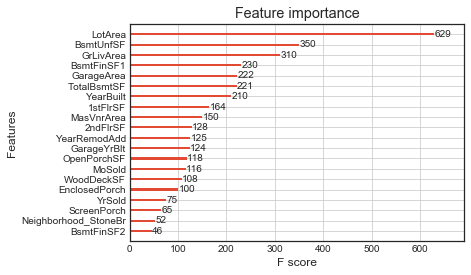

In [100]:
every_column_except_y= [col for col in train_data.columns if col not in ['Id']]
feat_rank.fit(train_data[every_column_except_y],Target)
plt.figure(figsize=[12,400])
#print(feat_rank.feature_importances_)
# plot
#fig, ax = plt.subplots(figsize=(100,12))
plot_importance(feat_rank,max_num_features=20)

In [ ]:
#most_imp_features = list( dict((k, v) for k, v in feat_rank.booster().get_fscore().items() if v >= 10).keys())
#print(most_imp_features)

In [103]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(train_data, Target, test_size = 0.3, random_state = 2)

In [61]:
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, train_size = .7, test_size = .3, 
                                        random_state = 2)#run model 10 times with 60%train data and 30%test data leaving 10%

Training Model
--

In [89]:
def train_model(train_data):
    learning_rate = ['0.06','0.07']
    print('Training Model...')
    for l in learning_rate:
        lr = float(l)
        est = ['600','800','1000','1200']
        for e in est:
            est = int(e)
            csbt =['0.2','0.4','0.6']
            for c in csbt:
                csbt = float(c)
                mxd = ['2','3','5','6']
                for m in mxd:
                    mxd = int(m)
                    #grad3 = GradientBoostingRegressor(n_estimators = est, learning_rate = lr)
                    grad3 = XGBRegressor(n_estimators = est, learning_rate = lr, colsample_bytree= csbt, max_depth = mxd,
                                             seed = 7) 
                    base_results = model_selection.cross_validate(grad3, train_data, Target, cv = cv_split)
                    grad3.fit(train_data, Target, eval_metric='rmse')
                    train_score_mean = base_results['train_score'].mean()*100
                    test_score_mean = base_results['test_score'].mean()*100
                    #rmse = np.sqrt(((base_results['test_score']-base_results['train_score'])**2)).mean()
                    rmse = np.sqrt(metrics.mean_squared_error(base_results['test_score'],base_results['train_score']).mean())
                    print ("for lr: {}, est: {}, csbt: {}, mxd: {}, tr_acc: {}, tst_acc: {}, rmse: {}".format(l, e, c, m, train_score_mean, test_score_mean, rmse))
    print("Model Training Completed")  
    return grad3

In [ ]:
trained_model = train_model(train_data = train_data)

Model with best parameters
--

In [110]:
def best_model(train_data, learning_rate, est):
    lr = float(learning_rate)
    est = int(est)
    print('Training Model...')
    #grad3 = GradientBoostingRegressor(n_estimators = est, learning_rate = lr)
    bestmod = XGBRegressor(n_estimators = est, learning_rate = lr, colsample_bytree=0.4, max_depth =3, seed=7) #,reg_alpha=0.8,reg_lambda=0.5)
    base_results = model_selection.cross_validate(bestmod, train_data, Target, cv = cv_split)
    bestmod.fit(train_data, Target, eval_metric='rmse')
    train_score_mean = base_results['train_score'].mean()*100
    test_score_mean = base_results['test_score'].mean()*100
    #rmse = np.sqrt(((base_results['test_score']-base_results['train_score'])**2)).mean()
    rmse = np.sqrt(metrics.mean_squared_error(base_results['test_score'],base_results['train_score']).mean())
    print ("for lr: {}, est: {}, tr_acc: {}, tst_acc: {}, rmse: {}".format(lr, est, train_score_mean, test_score_mean, rmse))
    print("Model Training Completed")  
    return bestmod

In [114]:
better_model = best_model(train_data = train_data,
                           learning_rate = 0.05,
                           est = 590)     

Training Model...
for lr: 0.05, est: 590, tr_acc: 98.74179943476963, tst_acc: 92.28114343820712, rmse: 0.0648622261615432
Model Training Completed


RMSE
--

In [44]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train_data, Target, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [45]:
rmse = rmse_cv(better_model).mean()
print(rmse)

22079.74952129306


Output Predictions
--

In [115]:
#predictions 2
preds = better_model.predict(test_data)
submit = pd.DataFrame({'Id': test_data.index, 'SalePrice': preds})
submit.to_csv(f'{PATH2}submission_1108_v2.csv', index=False)